# A Multiagent transportation system

Auteur : Philippe Mathieu, [CRISTAL Lab](https://www.cristal.univ-lille.fr/), [SMAC Team](https://www.cristal.univ-lille.fr/?rubrique26&id=7), [University of Lille](http://www.univ-lille1.fr), email : philippe.mathieu@univ-lille.fr

Contributeurs : Corwin Fèvre (CRISTAL/SMAC , CRISTAL/OSM)

Creation : 15/01/2020


## Principe général


Cette feuille fait suite à [mas_basics_fr.ipynb](mas_basics_fr.ipynb) qui fournit les bases de la construction d'un système multi-agents sur un reseau social.
En s'appuyant sur le même modèle, cette feuille a pour objectif de montrer comment réaliser un système de transport routier et plus précisément modéliser un système de co-voiturage à l'aide d'un système multi-agents.

Des passagers avec leurs propres objectifs cherchent à arriver à destination en partant avec des conducteurs qui les "rapprochent". Un passager aura sans doute besoin de plusieurs étapes de co-voiturage afin d'arriver à ses fins. Bien évidemment ces différents agents essayent de minimiser les distances parcourues en prenant le chemin le plus court (ce qui n'amène pas forcément au trajet le plus rapide)

In [1]:
import networkx as nx
import random as random
import matplotlib.pyplot as plt
import itertools
import numpy as np
from timeit import default_timer as timer
from math import ceil, floor
import copy
import pandas as pd

## L'environnement : le réseau routier
Dans une simulation de trafic, l'environnement est évidemment constitué par le réseau routier. Celui-ci peut être réalisé à un grain plus ou moins fin (route triviale entre 2 points, route avec largeur de voies, inclinaison de la route), et à des échelles plus ou moins précises (une simple route, à une ou plusieurs voies).
Dans cette feuille nous nous intéressons à la modélisation d'une pseudo ville, avec des routes bi-directionnelles constituées d'un arc simple entre deux points. En quelque sorte, un graphe de routes, à la manière de Manhattan. 
Pour cela nous générons à l'aide de la librairie `NetworkX` un graphe de taille fixée (fonction `grid_2d_graph`), sur lequel nous supprimons quelques arrêtes (fonction `remove_edge`) afin que les recherches de plus court chemin aient un intérêt.

In [5]:
#fonction permettant de générer un graphe en grille aléatoire avec perturbation d'arête 
#n indique la taille de la grille initiale (constituée de n^2 noeuds)
#coef suppr détermine le coefficient de suppression des arêtes
#show précise si on souhaite afficher le graphe ou non
def generate_2D_graph(n, coef_suppr=False, show=False):
    graph = nx.grid_2d_graph(n, n)  # n x n grid

    if coef_suppr != False:
        nb_suppr = int(len(list(graph.nodes))*coef_suppr)
        random_edge(graph, nb_suppr, delete=True)
    pos = nx.spring_layout(graph, iterations=100)

    graph.remove_nodes_from(list(nx.isolates(graph)))
    graph = graph.to_directed()
    
    if show:
        nx.draw(graph, pos, node_color='b', node_size=20, with_labels=False)
        plt.title("Road network")
        plt.show()
        
    return graph

#ajoute ou supprime un nombre d'arêtes dans un graphe
def random_edge(graph, nb_edges, delete=True):
    edges = list(graph.edges)
    nonedges = list(nx.non_edges(graph))

    # random edge choice
    if delete:
        # delete chosen edge
        chosen_edges = random.sample(edges, nb_edges)
        for edge in chosen_edges :
            graph.remove_edge(edge[0], edge[1])
    # add new edge
    else:
        chosen_nonedges = random.sample(nonedges, nb_edges)
        for non_edge in chosen_nonedges:
            graph.add_edge(non_edge[0], non_edge[1])

    return graph

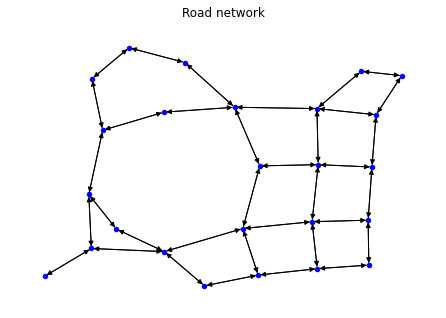

In [15]:
graph = generate_2D_graph(5, coef_suppr=0.2, show=True)

## Les Agents

Les agents de notre système disposent toujours d'un identifiant unique `id` et d'un état `alive?` indiquant s'ils sont vivants ou morts. Cet état indique leur activité dans le système : si ils sont vivants, ils sont actifs et
 interagissent avec leur environnement, sinon ils sont considérés comme sortis du système.
 Dans ce système de co-voiturage il y a 2 types d'agents:
 - les conducteurs
 - les passagers
 
 Quels qu'ils soient, pour simplifier, ils se déplacent de noeud en noeud sur le graphe

In [16]:
class Agent:
    def __init__(self, id):
        self.id = id
        self.alive = True
    
    def update(self) -> None:
        pass
    
    def decide(self) -> None:
        pass

### L'agent conducteur
Un agent conducteur est caractérisé par un noeud de destination `final`, un trajet à effectuer (succession de positions contiguës qu'il va parcourir) `trip` et un noeud indiquant sa position actuelle `current`.
À chaque pas de simulation, il supprime le premier élément de son trajet et met à jour le noeud actuel, simulant ainsi une avancée d'un pas dans son voyage.
Pour des raisons de simplicité, il avance obligatoirement à chaque pas de simulation d'un noeud du trajet et meurt quand il est arrivé au bout.

In [28]:
class DriverAgent(Agent):
    def __init__(self, id, trip):
        super().__init__(id)
        self.final = trip[-1]
        self.current = trip[0]
        self.trip = trip
        self.alive = True
        
    def to_string(self):
        print("I am driver",self.id,"- trip:",self.trip)
        
    def update(self) :
        pass
            
    def decide(self) :
        if len(self.trip)>1:
            old = self.trip.pop(0)
            self.current = self.trip[0]
            print("Driver",self.id,"moving from",old,"to",self.current)
        else :
            self.alive = False
            
            print("Driver",self.id,"arrived")         

Maintenant que l'on a un conducteur, on peut simuler l'avancée de ce conducteur dans le graphe défini précédemment. Afin de donner un peu "d'intelligence" à nos conducteurs on leur passe toujours le chemin le plus court d'un point à un autre (fonction `shortest_path`).

In [29]:
# on récupère 2 noeuds aléatoires dans le graphe
n1, n2 = random.sample(list(graph.nodes),2) 
# on récupère le chemin le plus court entre ces deux noeuds
trip = nx.shortest_path(graph, n1, n2)
#puis on créer un agent conducteur et on associe ce chemin à son itinéraire
d = DriverAgent(0, trip)

In [30]:
d.to_string()
#tant que le conducteur n'est pas arrivé à destination
while d.alive == True:
    #il fait une action
    d.decide()

I am driver 0 - trip: [(0, 1), (1, 1), (2, 1), (2, 0)]
Driver 0 moving from (0, 1) to (1, 1)
Driver 0 moving from (1, 1) to (2, 1)
Driver 0 moving from (2, 1) to (2, 0)
Driver 0 arrived


### L'agent passager
Comme pour l'agent conducteur, un agent passager dispose d'un noeud de départ `start`, d'un noeud d'arrivée `final` et d'un noeud actuel `current`.
Son but est de rejoindre son noeud d'arrivée en empruntant le véhicule de conducteurs passant par son noeud, tel un auto-stoppeur. Il n'a donc pas de `trip`. À chaque pas de simulation, il recherchera sur son noeud si il y a un ou plusieurs agents conducteurs lui permettant d'avancer dans son objectif, dans le cas contraire il reste sur son noeud. Quand il arrive à sa position finale, il meurt.

In [31]:
class RiderAgent(Agent):
    def __init__(self, id, start, final, strategy='transition'):
        super().__init__(id)
        self.start = start
        self.current = start
        self.final = final
        
    def to_string(self):
        print("I am rider",self.id,"- dep:",self.start,", arr:",self.final)
                 
            
    def update(self):
        cur_node = self.current
        global agentList
        #si il existe au moins un véhicule sur ce noeud actuellement
        #alors on s'interroge sur une eventuelle prise en charge
        caragent = [agent for agent in agentList if (agent.__class__.__name__ == "DriverAgent" and agent.current == self.current and len(agent.trip)>1)]
        if len(caragent) > 0:
            best_driver = None
            for ad in caragent:
                next_node = ad.trip[1]
                #on effectue la différence de la distance actuelle entre le passager et son noeud d'arrivé
                #avec la distance potentielle en empruntant le véhicule.
                #Si la valeur est positive, alors le véhicule fait avancer le passager dans son trajet.
                contrib = nx.shortest_path_length(graph, source=self.current, target=self.final) - nx.shortest_path_length(graph, source=next_node, target=self.final)
                if contrib > 0:
                    best_driver = ad
                    break
            
            if best_driver != None :
                #le passager le prends et mets à jour sa position
                new_node = best_driver.trip[1]
                print("Agent rider",self.id,"move from",self.current,"to",new_node,"using car",best_driver.id)
                #si c'est son arrivée, l'agent meurt
                if new_node == self.final:
                    print("Rider n°",self.id,"arrived")
                    self.alive = False
                    return
            #sinon l'agent ne bouge pas    
            else : 
        
                print("Agent rider",self.id,"doesn't move")
                new_node = cur_node
            
        #sinon l'agent ne bouge pas    
        else:
            
            print("Agent rider",self.id,"doesn't move")
            new_node = cur_node
        
        self.v_r = new_node
        
    def decide(self):
        pass

On peut alors créer des agents conducteurs et des agents passagers :

In [32]:
agentList = []

# 10 conducteurs
for i in range(10) :
    n1, n2 = random.sample(list(graph.nodes),2) 
    trip = nx.shortest_path(graph, n1, n2)
    d = DriverAgent(i, trip)
    agentList.append(d)
  
# 5 passagers
for i in range(10,15):
    #on récupère 2 noeuds aléatoires dans le graphe
    n1, n2 = random.sample(list(graph.nodes),2) 
    #puis on créer un agent passager avec pour départ et destination ces noeuds
    r = RiderAgent(i, n1, n2)
    agentList.append(r)


Et les faire évoluer dans notre environnement : Pour tester on prend les agents dans l'ordre de la liste et on continue l'éxécution tant que les conducteurs ne sont pas tous arrivés à destination.

In [34]:
for a in agentList :
    a.to_string()
    
while len([agent for agent in agentList if (agent.__class__.__name__ == "DriverAgent")]) > 0:
    for a in agentList:
        a.update()
        a.decide()
        
    for a in agentList:
        if a.alive == False:
            agentList.remove(a)
        

I am rider 10 - dep: (2, 2) , arr: (3, 0)
I am rider 11 - dep: (1, 4) , arr: (0, 2)
I am rider 12 - dep: (3, 1) , arr: (2, 2)
I am rider 13 - dep: (1, 2) , arr: (0, 0)
I am rider 14 - dep: (4, 3) , arr: (0, 2)


### Le SMA

Afin de faire évoluer des ensembles importants d'agents, et cela de manière équitable, on instancie un "Système Multi-Agents" qui crée les agents et gère les tours de parole. A chaque "tour' chaque agent a la parole et décide de ce qu'il veut faire : il est autonome. La méthode `run` prend en paramètre le nombre de tours de paroles. 
On rappelle que les agents passagers et conducteurs sont considérés `alive` tant qu'ils ne sont pas arrivés à leur destination. Le SMA s'occupe de mettre à jour la liste des agents du système en fonction de leur état. Il s'occupe par ailleurs de stocker les informations macroscopiques à collecter des agents arrivés à destination (temps de trajet etc...).

In [42]:
import random
class SMA:
    def __init__(self, verbose=False):
        self.tick=0
        self.resetTicks()
        self.agentList = []
        self.graph = None
        self.verbose = verbose
        #déclaration variable de la recup des données
        self.data = {}

    def resetTicks(self):
        tick=0
          
    def setRoadGraph(self,graph):
        self.graph = graph
        
    def addAgent(self,ag):
        self.agentList.append(ag)
 
    def run(self,rounds):
        #initialisation
        self.data["mean_travel_time_r"] = []
        
        for i in range(0,rounds):
            self.runOnce()

    def runOnce(self):
        self.tick+=1
        #random.shuffle(self.agentList)
        for ag in self.agentList :
            ag.update()
            ag.decide()
            
        for ag in self.agentList:
            if ag.alive == False:
                #si c'est un agent passager
                if ag.__class__.__name__ == "RiderAgent":
                    #on recupère son temps total d'attente
                    self.data["mean_travel_time_r"].append(ag.travel_time)
                self.agentList.remove(ag)
                
        if self.verbose == True:      
            print("tick "+str(self.tick)+" ended")

On réécrit légèrement nos précédents agents afin qu'ils se basent maintenant sur le graphe et la liste des agents du sma.

In [39]:
class RiderAgent(Agent):
    def __init__(self, id, start, final, strategy='transition'):
        super().__init__(id)
        self.start = start
        self.current = start
        self.final = final
        self.travel_time = 0
        
    def to_string(self):
        print("I am rider",self.id,"- dep:",self.start,", arr:",self.final)
                 
            
    def update(self):
        cur_node = self.current
        #on retire ici cette ligne
        #global agentList
       
        #ici on modifie en sma.agentList
        caragent = [agent for agent in sma.agentList if (agent.__class__.__name__ == "DriverAgent" and agent.current == self.current and len(agent.trip)>1)]
        if len(caragent) > 0:
            best_driver = None
            for ad in caragent:
                next_node = ad.trip[1]
                #ici en sma.graph
                contrib = nx.shortest_path_length(sma.graph, source=self.current, target=self.final) - nx.shortest_path_length(sma.graph, source=next_node, target=self.final)
                if contrib > 0:
                    best_driver = ad
                    break
            
            if best_driver != None :
                new_node = best_driver.trip[1]
                if sma.verbose == True:
                    print("Agent rider",self.id,"move from",self.current,"to",new_node,"using car",best_driver.id)
                if new_node == self.final:
                    if sma.verbose == True:
                        print("Rider n°",self.id,"arrived")
                    self.alive = False
                    return    
            else : 
                if sma.verbose == True:
                    print("Agent rider",self.id,"doesn't move")
                new_node = cur_node
               
        else:  
            if sma.verbose == True:
                print("Agent rider",self.id,"doesn't move")
            new_node = cur_node
        
        self.current = new_node
        self.travel_time += 1
        
    def decide(self):
        pass

In [40]:
class DriverAgent(Agent):
    def __init__(self, id, trip):
        super().__init__(id)
        self.final = trip[-1]
        self.current = trip[0]
        self.trip = trip
        
    def to_string(self):
        print("I am driver",self.id,"- trip:",self.trip)
        
    def update(self) :
        pass
            
    def decide(self) :
        if len(self.trip)>1:
            old = self.trip.pop(0)
            self.current = self.trip[0]
            if sma.verbose == True:
                print("Driver",self.id,"moving from",old,"to",self.current)
        else :
            self.alive = False
            if sma.verbose == True:
                print("Driver",self.id,"arrived")  

On peut ainsi créer notre SMA, lui associer des passagers et des conducteurs et effectuer 6 runs par exemple.

In [43]:
sma = SMA(verbose=True)
sma.graph = graph

#conducteurs
for i in range(5) :
    n1, n2 = random.sample(list(sma.graph.nodes),2) 
    trip = nx.shortest_path(sma.graph, n1, n2)
    d = DriverAgent(i, trip)
    sma.addAgent(d)
  
#passagers
for i in range(5,10):
    n1, n2 = random.sample(list(sma.graph.nodes),2) 
    r = RiderAgent(i, n1, n2)
    sma.addAgent(r)

sma.run(6)

Driver 0 moving from (1, 0) to (1, 1)
Driver 1 moving from (0, 2) to (0, 1)
Driver 2 moving from (0, 0) to (1, 0)
Driver 3 moving from (3, 0) to (4, 0)
Driver 4 moving from (1, 4) to (1, 3)
Agent rider 5 doesn't move
Agent rider 6 doesn't move
Agent rider 7 doesn't move
Agent rider 8 doesn't move
Agent rider 9 doesn't move
tick 1 ended
Driver 0 arrived
Driver 1 moving from (0, 1) to (1, 1)
Driver 2 moving from (1, 0) to (1, 1)
Driver 3 moving from (4, 0) to (4, 1)
Driver 4 arrived
Agent rider 5 doesn't move
Agent rider 6 doesn't move
Agent rider 7 doesn't move
Agent rider 8 doesn't move
Agent rider 9 doesn't move
tick 2 ended
Driver 1 arrived
Driver 2 moving from (1, 1) to (1, 2)
Driver 3 moving from (4, 1) to (4, 2)
Agent rider 5 doesn't move
Agent rider 6 doesn't move
Agent rider 7 doesn't move
Agent rider 8 move from (4, 2) to (4, 3) using car 3
Agent rider 9 move from (1, 2) to (1, 3) using car 2
tick 3 ended
Driver 2 moving from (1, 2) to (1, 3)
Driver 3 moving from (4, 2) to (4, 

### L'agent générateur de trafic

Pour une simulation réaliste, comme les Conducteurs et les Passagers arrivent vite à destination, il est souhaitable d'avoir un flux continu de conducteurs et passagers. On crée pour cela un agent "générateur de trafic" qui a pour objectif, d'alimenter en permanence la simulation.
On notera que pour la première fois, nous créons ici non seulement un agent qui ne se voit pas, mais qui ne bouge pas non plus. C'est maintenant l'agent `GeneratorAgent` qui va s'occuper de créer les autres agents.

In [44]:
class GeneratorAgent(Agent):
    def __init__(self, current_id, max_drivers, max_riders, seed=None):
        super().__init__(current_id)
        self.n_id = current_id+1
        self.seed = seed
        if self.seed!=None:
            random.seed(seed)
        
        self.max_drivers = max_drivers
        self.max_riders = max_riders
        
    #gestion des id unique    
    def next_id(self):
        self.n_id += 1
        return self.n_id

    #genere les agents conducteurs
    def driverAgentGenerator(self):
        n1, n2 = random.sample(list(sma.graph.nodes),2) 
        trip = nx.shortest_path(sma.graph, n1, n2)
        d = DriverAgent(self.next_id(), trip)
        sma.addAgent(d)
        
    #genere les agents passagers
    def riderAgentGenerator(self):
        n1, n2 = random.sample(list(sma.graph.nodes),2) 
        r = RiderAgent(self.next_id(), n1, n2)
        sma.addAgent(r)
        
    def update(self):
        
        #on récupère le nombre d'agents dans le système
        nb_drivers = len([agent for agent in sma.agentList if (agent.__class__.__name__ == "DriverAgent")])
        nb_riders = len([agent for agent in sma.agentList if (agent.__class__.__name__ == "RiderAgent")])
        
        #puis on complète par rapport au nombre maximal fixé
        driver_difference = self.max_drivers - nb_drivers
        rider_difference = self.max_riders - nb_riders
        
        for i in range(driver_difference):
            self.driverAgentGenerator()
        if sma.verbose == True:
            print(driver_difference,"drivers generated.")
            
        for i in range(rider_difference):
            self.riderAgentGenerator()
        if sma.verbose == True:
            print(rider_difference,"riders generated.") 
        
    def decide(self):
        pass
        

On définit maintenant les paramètres de notre simulation à l'aide de 4 variables:

In [50]:
SIZE_MAP = 5 #graphe en grille donc 5x5 noeuds
MAX_NB_DRIVERS = 20
MAX_NB_RIDERS = 10
NB_RUN = 200

puis on lance le SMA !

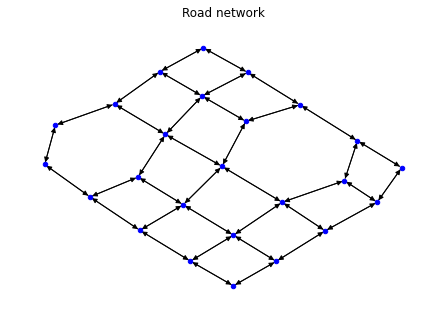

In [51]:
sma = SMA()
sma.setRoadGraph(generate_2D_graph(SIZE_MAP, coef_suppr=0.1, show=True))
sma.addAgent(GeneratorAgent(0,MAX_NB_DRIVERS,MAX_NB_RIDERS))
sma.run(NB_RUN)

In [49]:
print("Temps moyen de trajet des passagers arrivés a destination:", np.mean(sma.data["mean_travel_time_r"]),"tours de paroles")

Temps moyen de trajet des passagers arrivés a destination: 14.252100840336135 tours de paroles


## Expérimentations et Résultats
Nous avons défini le coeur de notre simulateur de trafic, il s'agit maintenant de mettre en place des indicateurs afin de déterminer si une configuration est meilleure qu'une autre et pourquoi.

### Le temps de trajet :
On peut émettre une hypothèse simple : plus il y a de véhicules disponibles, plus il y a de possibilités d'acheminement pour les passagers et donc ces derniers arrivent vite à destination. En conséquence, le temps moyen de trajet des agents passagers devrait décroître en fonction du nombre d'agents conducteurs.

Pour démontrer simplement ce cas de figure, il est necessaire d'effectuer plusieurs simulations avec le même réseau routier, le même nombre de passagers mais en faisant varier le nombre de conducteurs.

In [53]:
SIZE_MAP = 5
MAX_NB_DRIVERS = np.arange(5,50,3)
MAX_NB_RIDERS = 20
NB_RUN = 200

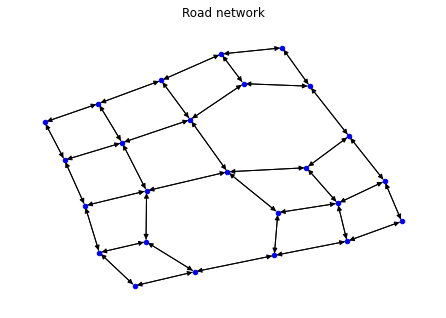

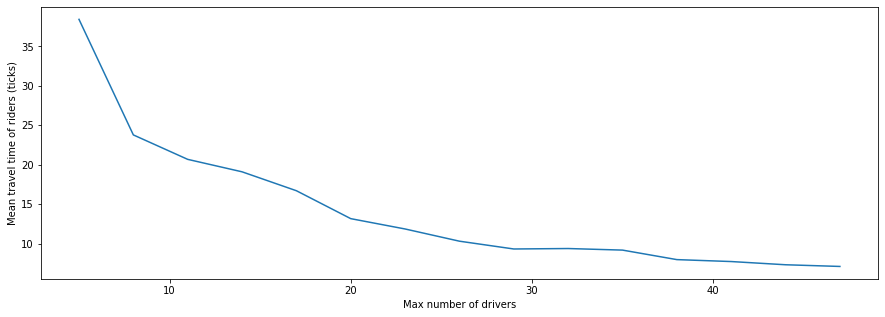

In [54]:
mean_travel_time_per_d = []
graph = generate_2D_graph(SIZE_MAP, coef_suppr=0.1, show=True)


for nb_d in MAX_NB_DRIVERS :
    sma = SMA()
    sma.setRoadGraph(graph)
    sma.addAgent(GeneratorAgent(0,nb_d,MAX_NB_RIDERS, seed=42))
    sma.run(NB_RUN)
    mean_travel_time_per_d.append(np.mean(sma.data["mean_travel_time_r"]))
    
f = plt.figure(figsize=(15, 5))
plt.plot(MAX_NB_DRIVERS,mean_travel_time_per_d)
plt.xlabel('Max number of drivers')
plt.ylabel("Mean travel time of riders (ticks)")
#plt.legend()
plt.show()

Même expérience mais avec un réseau routier plus important :

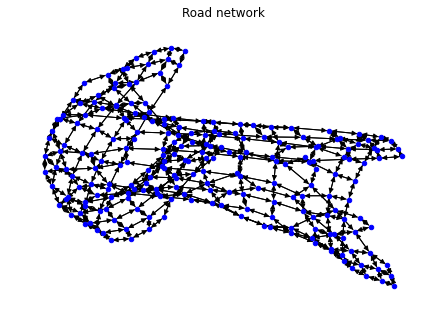

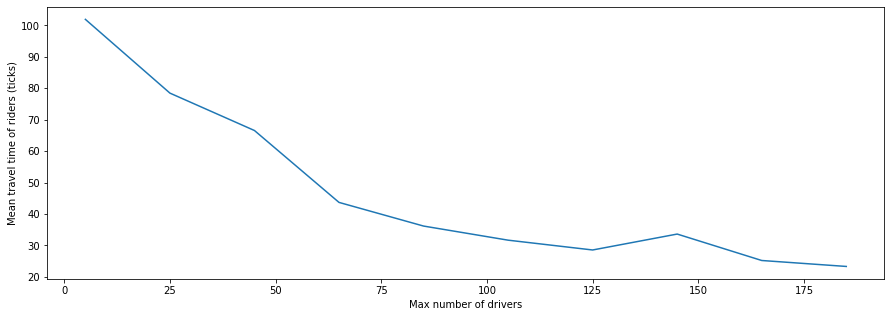

In [55]:
SIZE_MAP = 15
MAX_NB_DRIVERS = np.arange(5,200,20)
MAX_NB_RIDERS = 20
NB_RUN = 200

mean_travel_time_per_d = []
graph = generate_2D_graph(SIZE_MAP, coef_suppr=0.1, show=True)


for nb_d in MAX_NB_DRIVERS :
    sma = SMA()
    sma.setRoadGraph(graph)
    sma.addAgent(GeneratorAgent(0,nb_d,MAX_NB_RIDERS, seed=42))
    sma.run(NB_RUN)
    mean_travel_time_per_d.append(np.mean(sma.data["mean_travel_time_r"]))
    
f = plt.figure(figsize=(15, 5))
plt.plot(MAX_NB_DRIVERS,mean_travel_time_per_d)
plt.xlabel('Max number of drivers')
plt.ylabel("Mean travel time of riders (ticks)")
#plt.legend()
plt.show()

# Bibliographie

- Fèvre Corwin, Hayfa Zgaya-Biau, Philippe Mathieu, Slim Hammadi, Multi-agent Systems and R-Trees for Dynamic and Optimised Ridesharing. IEEE International Conference on Systems, Man, and Cybernetics, Oct 2021, Melbourne, Australia. pp.1352--1358
- Philippe Mathieu, Antoine Nongaillard. Effective evaluation of autonomous taxi fleets
ICAART 2018 - 10th International Conference on Agents and Artificial Intelligence, Jan 2018, Funchal, Portugal 
- Antoine Nongaillard, Philippe Mathieu. L'évaluation efficace de flottes de taxis autonomes
Journées Francophones sur les Systèmes Multi-Agents (JFSMA 2017), Jul 2017, Caen, France 
- Alexandre Bonhomme, Philippe Mathieu, Sébastien Picault. A Versatile MultiAgent Traffic Simulator Framework Based on Real Data. International Journal on Artificial Intelligence Tools (IJAIT), 2016, Special Issue on 26th IEEE International Conference on Tools with Artificial Intelligence (ICTAI-2014), 25 (1), pp.20.
